In [2]:
### import tensorflow as tf
import os
from os.path import isfile, join
import numpy as np
import shutil
from tensorflow import keras
from pathlib import Path
from IPython.display import display, Audio
import subprocess

In [3]:

import os
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Path to your dataset directory
dataset_directory = r'C:\Users\HP\Desktop\input\data\16000'

# List all speaker directories
speaker_directories = os.listdir(dataset_directory)

# Ignore specific file
file_to_ignore = 'tf_Wav_reader.py'

# Count the number of speakers
num_speakers = len(speaker_directories)
print(f"Number of Speakers: {num_speakers}")

# Iterate through speaker directories
for speaker_dir in speaker_directories:
    if speaker_dir == file_to_ignore:
        continue  # Skip the file you want to ignore
    speaker_path = os.path.join(dataset_directory, speaker_dir)

    # Count the number of audio clips for each speaker
    num_audio_clips = len(os.listdir(speaker_path))
    print(f"Speaker: {speaker_dir}, Number of Audio Clips: {num_audio_clips}")

   



Number of Speakers: 10
Speaker: Benjamin_Netanyau, Number of Audio Clips: 1500
Speaker: Daaman_Shah, Number of Audio Clips: 1500
Speaker: Jens_Stoltenberg, Number of Audio Clips: 1500
Speaker: Julia_Gillard, Number of Audio Clips: 1501
Speaker: Magaret_Tarcher, Number of Audio Clips: 1500
Speaker: Nelson_Mandela, Number of Audio Clips: 1500
Speaker: other, Number of Audio Clips: 2
Speaker: Rishit Saboo, Number of Audio Clips: 1500
Speaker: _background_noise_, Number of Audio Clips: 4


In [4]:
# Import the required packages
import os
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import librosa.display
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split



In [5]:
# Get the data directories
data_dir = r'C:\Users\HP\Desktop\input\data\16000'
clas= os.listdir(data_dir)
clas.pop(9)
clas.pop(8)
clas.pop(6)
claas =clas
claas

['Benjamin_Netanyau',
 'Daaman_Shah',
 'Jens_Stoltenberg',
 'Julia_Gillard',
 'Magaret_Tarcher',
 'Nelson_Mandela',
 'Rishit Saboo']

In [6]:
# get wav paths
def get_wav_paths(speaker):
    speaker_path = data_dir + speaker
    all_paths = [item for item in os.listdir(speaker_path)]
    return all_paths

In [7]:
nelson_mandela_paths = get_wav_paths(r"\Nelson_Mandela")
margaret_thatcher_paths = get_wav_paths(r"\Magaret_Tarcher")
benjamin_netanyau_paths = get_wav_paths(r"\Benjamin_Netanyau")
jens_stoltenberg_paths = get_wav_paths( r'\Jens_Stoltenberg')
julia_gillard_paths = get_wav_paths(r"\Julia_Gillard")
daaman_shah_paths =get_wav_paths(r"\Daaman_Shah")
rishit_saboo_paths =get_wav_paths(r"\Rishit Saboo")

noise1_paths = get_wav_paths(r"\_background_noise_")
noise2_paths = get_wav_paths(r"\other")

In [8]:
# load the data
def load_wav(wav_path, speaker):
    with tf.compat.v1.Session(graph=tf.compat.v1.Graph()) as sess:
        wav_path = data_dir + speaker + "/" + wav_path
        wav_filename_placeholder = tf.compat.v1.placeholder(tf.compat.v1.string, [])
        wav_loader = tf.io.read_file(wav_filename_placeholder)
        wav_decoder = tf.audio.decode_wav(wav_loader, desired_channels=1)
        wav_data = sess.run(
            wav_decoder, feed_dict={
                wav_filename_placeholder: wav_path
            }).audio.flatten().reshape((1, 16000)) #16000
        sess.close()
    return wav_data

In [9]:
# create training data
def generate_training_data(speaker_paths, speaker, label):
    wavs, labels = [], []
    for i in tqdm(speaker_paths):
        wav = load_wav(i, speaker)
        wavs.append(wav)
        labels.append(label)
    return wavs, labels

In [10]:
nelson_mandela_wavs, nelson_mandela_labels = generate_training_data(nelson_mandela_paths, r"/Nelson_Mandela", 0) 
margaret_thatcher_wavs, margaret_thatcher_labels = generate_training_data(margaret_thatcher_paths, r"\Magaret_Tarcher", 1) 
benjamin_netanyau_wavs, benjamin_netanyau_labels = generate_training_data(benjamin_netanyau_paths, r"\Benjamin_Netanyau", 2) 
jens_stoltenberg_wavs, jens_stoltenberg_labels = generate_training_data(jens_stoltenberg_paths, r"\Jens_Stoltenberg", 3) 
julia_gillard_wavs, julia_gillard_labels = generate_training_data(julia_gillard_paths, r"\Julia_Gillard", 4) 
rishit_saboo_wavs ,rishit_saboo_labels = generate_training_data(rishit_saboo_paths,r"/Rishit Saboo", 5)
daaman_shah_wavs,daaman_shah_labels =generate_training_data(daaman_shah_paths,r"/Daaman_Shah", 6)

  0%|          | 0/1500 [00:00<?, ?it/s]

100%|██████████| 1500/1500 [00:15<00:00, 95.78it/s]


In [11]:
# remove the extra wav for Julia Gillard
julia_gillard_labels = julia_gillard_labels[1:]
julia_gillard_wavs = julia_gillard_wavs[1:]

In [12]:
all_wavs = nelson_mandela_wavs + margaret_thatcher_wavs + benjamin_netanyau_wavs + jens_stoltenberg_wavs + julia_gillard_wavs + daaman_shah_wavs + rishit_saboo_wavs
all_labels = nelson_mandela_labels + margaret_thatcher_labels + benjamin_netanyau_labels + jens_stoltenberg_labels + julia_gillard_labels + daaman_shah_labels + rishit_saboo_labels

In [13]:
from scipy.io.wavfile import read
from scipy.io.wavfile import write
from random import randint

def cut_random_section(noise2, size2):
    size21 = noise2.size
    starting_point2 = randint(0,(noise2.size - size2))
    end_point2 = starting_point2 + size2
    noise_cut_part2 = noise2[starting_point2:end_point2]
    return noise_cut_part2

def mix(audio1, noise1, snr1):
    audio_max = max(audio1)
    if audio_max==0:
        audio_max = int(np.random.uniform(0.7,1)*32767)
    audio1 = audio1*1.
    audio1 = audio1/audio_max
    noise1 = cut_random_section(noise1, audio1.size)
    noise1 = noise1*1.
    noise1 = noise1/max(noise1)
    gain = pow(10,(snr1/10.))
    numerator = np.mean(abs(audio1)**2)
    denominator = numerator/gain
    noise_power = np.mean(abs(noise1)**2)
    mult_value = (denominator/noise_power)**0.5
    noisy1 = audio1 + noise1*mult_value
    if max(audio1)==0:
        noisy1 = noise1
    else:    
        noisy1 = noisy1/max(noisy1)
    noisy1 = np.array(noisy1*audio_max, dtype='int16')
    return noise1*mult_value, mult_value, noisy1

noise_wavs = []
noise_labels = []
snr_dB = 10
for i in range(len(all_wavs)):
    for noise in os.listdir(data_dir + r'\other'):
        fs, noise_file = read(data_dir + r'\other/' + noise)
        x = all_wavs[i][0]
        noise_temp, mult_value, noisy = mix(x, noise_file, snr_dB)
        if noisy.any() != 0:
            noise_wavs.append(noisy)
            noise_labels.append(all_labels[i])
    for noise in os.listdir(data_dir + r'\_background_noise_'):
        fs, noise_file = read(data_dir + r'\_background_noise_/' + noise)
        x = all_wavs[i][0]
        if len(noise_file.shape) > 1:
            noise_file = np.reshape(noise_file, (noise_file.shape[0]*noise_file.shape[1]))
        noise_temp, mult_value, noisy = mix(x, noise_file, snr_dB)
        if noisy.any() != 0:
            noise_wavs.append(noisy)
            noise_labels.append(all_labels[i]) 
    if i%200 == 0:
        print(i)

C:\Users\HP\AppData\Local\Temp\ipykernel_10912\3622996277.py:46: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, noise_file = read(data_dir + r'\_background_noise_/' + noise)


0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
9000
9200
9400
9600
9800
10000
10200
10400


In [14]:
for i in range(len(all_wavs)):
    noise_labels.append(all_labels[i])
    noise_wavs.append(all_wavs[i][0])
final_wavs = np.array(noise_wavs)
final_labels = np.array(noise_labels)

print(final_wavs.shape, final_labels.shape)

(11135, 16000) (11135,)


In [15]:
# split the dataset into training and testing set\
train_wavs, test_wavs, train_labels, test_labels = train_test_split(final_wavs, final_labels, test_size=0.2)

In [16]:
train_x, train_y = np.array(train_wavs), np.array(train_labels)
test_x, test_y = np.array(test_wavs), np.array(test_labels)

In [17]:
train_y = tf.keras.utils.to_categorical(train_y)
test_y = tf.keras.utils.to_categorical(test_y)

In [18]:
# MFCC Feature Extraction

train_x_new = []
test_x_new = []
INPUT_SHAPE = (126,40)

train_x_new = np.zeros((train_x.shape[0], INPUT_SHAPE[0], INPUT_SHAPE[1]), dtype=np.float64)

count = 0
for sample in train_x:
    mfcc = librosa.feature.mfcc(y=sample, sr=16000, hop_length=128, n_fft=256, n_mfcc=20)
    mfcc_delta = librosa.feature.delta(mfcc)[:10, :]
    mfcc_double_delta = librosa.feature.delta(mfcc, order=2)[:10, :]
    train_x_new[count, :, :20] = mfcc.T
    train_x_new[count, :, 20:30] = mfcc_delta.T
    train_x_new[count, :, 30:] = mfcc_double_delta.T
    count += 1
    if count%500 == 0:
        print('Train', count)
        
test_x_new = np.zeros((test_x.shape[0], INPUT_SHAPE[0], INPUT_SHAPE[1]), dtype=np.float64)

count = 0
for sample in test_x:
    mfcc = librosa.feature.mfcc(y=sample, sr=16000, hop_length=128, n_fft=256, n_mfcc=20)
    mfcc_delta = librosa.feature.delta(mfcc)[:10, :]
    mfcc_double_delta = librosa.feature.delta(mfcc, order=2)[:10, :]
    test_x_new[count, :, :20] = mfcc.T
    test_x_new[count, :, 20:30] = mfcc_delta.T
    test_x_new[count, :, 30:] = mfcc_double_delta.T
    count += 1
    if count%500 == 0:
        print('Test', count)

c:\Users\HP\Desktop\project\pro\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Train 500
Train 1000
Train 1500
Train 2000
Train 2500
Train 3000
Train 3500
Train 4000
Train 4500
Train 5000
Train 5500
Train 6000
Train 6500
Train 7000
Train 7500
Train 8000
Train 8500
Test 500
Test 1000
Test 1500
Test 2000


In [19]:
train_x_new = np.expand_dims(train_x_new, axis=3)
test_x_new = np.expand_dims(test_x_new, axis=3)
print(train_x_new.shape, test_x_new.shape)

(8908, 126, 40, 1) (2227, 126, 40, 1)


In [20]:
import tensorflow as tf
from tensorflow import keras

def residual_block(x, filters, conv_num=3, activation="relu"):
    s = keras.layers.Conv2D(filters, 1, padding="same")(x)

    for i in range(conv_num - 1):
        x = keras.layers.Conv2D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)

    x = keras.layers.Conv2D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)

    return keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

def create_model(speech_feature):
    model = tf.keras.Sequential()
   
    # First residual block
    inputs = tf.keras.layers.Input(shape=(126, 40, 1))
    x = residual_block(inputs, 128, 2)
    
    # Second residual block
    x = residual_block(x, 64, 2)
    
    # Dropout layer for regularization
    x = tf.keras.layers.Dropout(0.25)(x)
    
    # Flatten the output
    x = tf.keras.layers.Flatten()(x)
    
    # Fully connected layers
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(7, activation="softmax")(x)
    
    # Create the model
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer="Adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    
    return model
    
model = create_model("mfcc")
model.summary()

# Assuming train_x_new, train_y, test_x_new, and test_y are already defined
h= model.fit(x=train_x_new, y=train_y, epochs=5, validation_data=(test_x_new, test_y))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 126, 40,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 126, 40,   │      1,280 │ input_layer[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 126, 40,   │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 126, 40,   │    147,584 │ activation[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 40,   │        256 │ input_layer[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 126, 40,   │          0 │ conv2d_2[0][0],   │
│                     │ 128)              │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 126, 40,   │          0 │ add[0][0]         │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 20,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 63, 20,    │     73,792 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 63, 20,    │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 63, 20,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 63, 20,    │      8,256 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 63, 20,    │          0 │ conv2d_5[0][0],   │
│                     │ 64)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 63, 20,    │          0 │ add_1[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 31, 10,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 31, 10,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 19840)     │          0 │ dropout[0][0]   

 Total params: 2,808,647 (10.71 MB)

 Trainable params: 2,808,647 (10.71 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 248s 871ms/step - accuracy: 0.4601 - loss: 7.3441 - val_accuracy: 0.8509 - val_loss: 0.3704
Epoch 2/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 240s 860ms/step - accuracy: 0.8447 - loss: 0.4425 - val_accuracy: 0.9241 - val_loss: 0.2125
Epoch 3/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 241s 862ms/step - accuracy: 0.8922 - loss: 0.3075 - val_accuracy: 0.9385 - val_loss: 0.1809
Epoch 4/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 240s 860ms/step - accuracy: 0.9076 - loss: 0.2760 - val_accuracy: 0.9380 - val_loss: 0.1587
Epoch 5/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 240s 860ms/step - accuracy: 0.9225 - loss: 0.2384 - val_accuracy: 0.9389 - val_loss: 0.1818


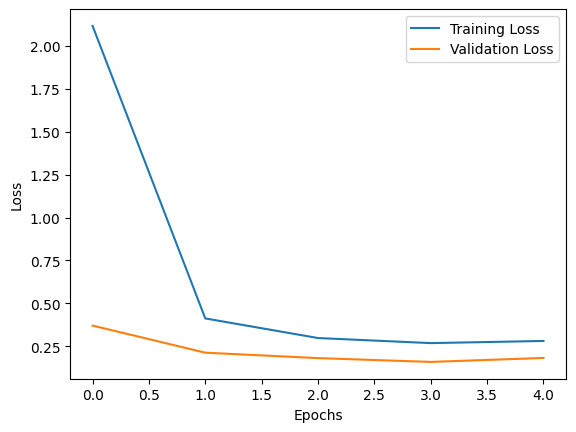

In [21]:
# graph when epoch are 10
from keras.callbacks import History
import matplotlib.pyplot as plt
# Plot training vs validation loss
plt.plot(h.history['loss'], label='Training Loss')
plt.plot(h.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
model.save('speakermo.h5')

In [1]:
from tensorflow.keras.models import load_model


In [2]:
loaded_model = load_model(r'speakermo.h5')

In [3]:
import numpy as np
import tensorflow as tf
import librosa

audio_data = r"newfolder\2024-05-11_13-30-33.wav"
predicted_speakers = []
def predict(audio_data,predicted_speakers):
# Example audio data 

# Load audio data
    n_audio_data, sr = librosa.load(audio_data, sr=16000)

# Split audio into frames
    frame_length = 16000  # Adjust as needed based on your hop size
    hop_length = 512     # Adjust as needed based on your hop size
    num_frames = (len(n_audio_data) - frame_length) // hop_length + 1

# Prepare an array to store processed frames
    processed_frames = np.zeros((num_frames, 126, 40))

    for i in range(num_frames):
        start = i * hop_length
        end = start + frame_length
        audio_frame = n_audio_data[start:end]

    # Calculate MFCC features and coefficients
        mfcc = librosa.feature.mfcc(y=audio_frame, sr=sr, hop_length=128, n_fft=256, n_mfcc=20)
        mfcc_delta = librosa.feature.delta(mfcc)[:10, :]
        mfcc_double_delta = librosa.feature.delta(mfcc, order=2)[:10, :]

    # Combine all features
        concatenated_features = np.concatenate((mfcc, mfcc_delta, mfcc_double_delta), axis=0)
    
    # Transpose the concatenated features

       
        concatenated_features = concatenated_features.T
    
    # Store processed frame
        processed_frames[i] = concatenated_features

# Reshape and expand dimensions to match the model's expected input shape
    new_data = np.expand_dims(processed_frames, axis=3)

# Make predictions
    predictions = loaded_model.predict(new_data)

    
    for i in np.argmax(predictions, axis=1):
        if i == 0:
            predicted_speakers.append("Nelson Mandela")
        elif i == 1:
            predicted_speakers.append("Margaret Thatcher")
        elif i == 2:
            predicted_speakers.append("Benjamin Netanyahu")
        elif i == 3:
            predicted_speakers.append("Jens Stoltenberg")
        elif i == 4:
            predicted_speakers.append("Julia Gillard")
        elif i == 5:
            predicted_speakers.append("Rishit Saboo")
        elif i == 6:
            predicted_speakers.append("Daaman Shah")
    
    from statistics import mode
    spock = mode(predicted_speakers)
    print(spock)

predict(audio_data,predicted_speakers)

c:\Users\HP\Desktop\project\pro\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step
Jens Stoltenberg


In [5]:
file=r"C:\Users\HP\Desktop\boo\beta\Julia_Gillard_combined.wav"

name = predict(file, predicted_speakers)
print(name)

117/117 ━━━━━━━━━━━━━━━━━━━━ 25s 216ms/step
Julia Gillard
None


In [4]:
from faster_whisper import WhisperModel 
def main3():

    model_size = "medium"

# Run on GPU with FP16
    model = WhisperModel(model_size, device="cuda", compute_type="float16")

    name2 = r"C:\Users\HP\Desktop\project\03.wav"
    name3 = [name2]

    segments, info = model.transcribe(name2, beam_size=7)

    print("Transcription :")
    print("Detected language '%s' with probability %f" % (info.language, info.language_probability))

    for segment in segments:
        print(segment.text)
    
    # name = predict(name3, labels)
    # print(name)
  
   
  
main3()


c:\Users\HP\Desktop\project\pro\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Transcription :
Detected language 'ja' with probability 0.991211
ここはカナダのセントロレース湾です。
今は4月。
毎年この時期になると、
たてごたあざらしの母親が出産をするため、
この流氷の上にやってくるんでそうです。
あ、いますね。
遠くからでもわかります。
ほら、見えますか?
あの大きい母親の影に隠れるように寄り添っているのが、
生まれたばかりの赤ちゃんですね。
おや?
母親が赤ちゃんを残して、海の中に入っていきました。
もうちょっと、赤ちゃんに近づいてみましょう。
ほら、ご覧ください。
これが、たてごたあざらしの赤ちゃんです。
かわいいですね。
今は体重およそ8キロ。
これから一人立ちを迎えるまでの3週間。
この赤ちゃんの成長ぶりを、
皆さんと一緒に見ていくことにしましょう。


In [28]:
predicted_labels

array([[2.09611356e-10, 6.30889982e-02, 9.36329603e-01, ...,
        5.73595113e-04, 1.24151134e-09, 9.60708704e-08],
       [2.01397097e-06, 2.77811137e-06, 2.61990429e-11, ...,
        9.99995232e-01, 4.95728944e-16, 2.26740386e-14],
       [5.16956896e-20, 2.96171800e-23, 3.85162200e-25, ...,
        2.50594387e-18, 9.42902090e-10, 1.00000000e+00],
       ...,
       [2.15291095e-07, 1.55559647e-13, 4.66147337e-14, ...,
        9.27781318e-09, 9.23123121e-01, 7.68766627e-02],
       [1.40828198e-35, 1.00000000e+00, 1.11477952e-10, ...,
        1.27423554e-18, 6.03579034e-30, 8.63236478e-21],
       [2.23981300e-09, 1.24918181e-03, 9.97512579e-01, ...,
        7.03811995e-04, 7.94046340e-09, 1.01799245e-07]], dtype=float32)

In [29]:
test_y

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [30]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report



# Get model predictions
test_predictions = loaded_model.predict(test_x_new)
predicted_labels = (test_predictions> 0.5).astype(int)  # Convert probabilities to binary predictions > 0.5).astype(int)

# Calculate precision, recall, and F1-score for each class
precision_scores = precision_score(test_y, predicted_labels, average=None)
recall_scores = recall_score(test_y, predicted_labels, average=None)
f1_scores = f1_score(test_y, predicted_labels, average=None)

# Print the metrics for each class
class_labels = ["Nelson Mandela", "Margaret Thatcher", "Benjamin Netanyau", "Jens Stoltenberg", "Julia Gillard","Daaman Shah","Rishit Saboo"]
for i, label in enumerate(class_labels):
    print(f"Metrics for {label}:")
    print(f"Precision: {precision_scores[i]:.4f}")
    print(f"Recall: {recall_scores[i]:.4f}")
    print(f"F1-Score: {f1_scores[i]:.4f}")
    print("--------------------------")




70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 196ms/step
Metrics for Nelson Mandela:
Precision: 0.9822
Recall: 0.8875
F1-Score: 0.9324
--------------------------
Metrics for Margaret Thatcher:
Precision: 0.9780
Recall: 0.9201
F1-Score: 0.9482
--------------------------
Metrics for Benjamin Netanyau:
Precision: 0.9869
Recall: 0.9233
F1-Score: 0.9540
--------------------------
Metrics for Jens Stoltenberg:
Precision: 0.9891
Recall: 0.8944
F1-Score: 0.9393
--------------------------
Metrics for Julia Gillard:
Precision: 0.9250
Recall: 0.8385
F1-Score: 0.8796
--------------------------
Metrics for Daaman Shah:
Precision: 1.0000
Recall: 0.9718
F1-Score: 0.9857
--------------------------
Metrics for Rishit Saboo:
Precision: 0.9685
Recall: 1.0000
F1-Score: 0.9840
--------------------------


In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss

# Calculate and print overall metrics
micro_precision = precision_score(test_y, predicted_labels, average='micro')
micro_recall = recall_score(test_y, predicted_labels, average='micro')
micro_f1 = f1_score(test_y, predicted_labels, average='micro')

print("Micro-average Metrics:")
print(f"Micro-Precision: {micro_precision:.4f}")
print(f"Micro-Recall: {micro_recall:.4f}")
print(f"Micro F1-Score: {micro_f1:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(test_y, predicted_labels, target_names=class_labels))

# Accuracy
accuracy = accuracy_score(test_y, predicted_labels)

# Precision, Recall, F1-Score
precision = precision_score(test_y, predicted_labels, average='weighted')
recall = recall_score(test_y, predicted_labels, average='weighted')
f1 = f1_score(test_y, predicted_labels, average='weighted')


# ROC-AUC (if it's a binary classification problem)
auc = roc_auc_score(test_y, test_predictions)

# Log Loss
log_loss_value = log_loss(test_y,test_predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'ROC-AUC: {auc}')
print(f'Log Loss: {log_loss_value}')

Micro-average Metrics:
Micro-Precision: 0.9752
Micro-Recall: 0.9169
Micro F1-Score: 0.9452

Classification Report:
                   precision    recall  f1-score   support

   Nelson Mandela       0.98      0.89      0.93       311
Margaret Thatcher       0.98      0.92      0.95       338
Benjamin Netanyau       0.99      0.92      0.95       326
 Jens Stoltenberg       0.99      0.89      0.94       303
    Julia Gillard       0.93      0.84      0.88       353
      Daaman Shah       1.00      0.97      0.99       319
     Rishit Saboo       0.97      1.00      0.98       277

        micro avg       0.98      0.92      0.95      2227
        macro avg       0.98      0.92      0.95      2227
     weighted avg       0.97      0.92      0.94      2227
      samples avg       0.92      0.92      0.92      2227

Accuracy: 0.9169286035024697
Precision: 0.9749623840581353
Recall: 0.9169286035024697
F1-Score: 0.9446015900741837
ROC-AUC: 0.996516122398115
Log Loss: 0.18168169276471538


c:\Users\HP\Desktop\project\pro\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HP\Desktop\project\pro\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss

# Assuming y_true are the true labels and y_pred are the predicted labels
# y_pred_prob are the predicted probabilities for the positive class

# Accuracy
accuracy = accuracy_score(test_y, predicted_labels)

# Precision, Recall, F1-Score
precision = precision_score(test_y, predicted_labels, average='weighted')
recall = recall_score(test_y, predicted_labels, average='weighted')
f1 = f1_score(test_y, predicted_labels, average='weighted')

# Confusion Matrix
conf_matrix = confusion_matrix(test_y.argmax(axis=1),predicted_labels.argmax(axis=1))

# ROC-AUC (if it's a binary classification problem)
auc = roc_auc_score(test_y, test_predictions)

# Log Loss
log_loss_value = log_loss(test_y,test_predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'Confusion Matrix: \n{conf_matrix}')
print(f'ROC-AUC: {auc}')
print(f'Log Loss: {log_loss_value}')

Accuracy: 0.9169286035024697
Precision: 0.9749623840581353
Recall: 0.9169286035024697
F1-Score: 0.9446015900741837
Confusion Matrix: 
[[309   0   0   0   2   0   0]
 [ 15 311   0   1  11   0   0]
 [ 17   4 301   2   2   0   0]
 [ 19   2   2 271   9   0   0]
 [ 54   1   2   0 296   0   0]
 [  0   0   0   0   0 310   9]
 [  0   0   0   0   0   0 277]]
ROC-AUC: 0.996516122398115
Log Loss: 0.18168169276471538


c:\Users\HP\Desktop\project\pro\Lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


with normalization


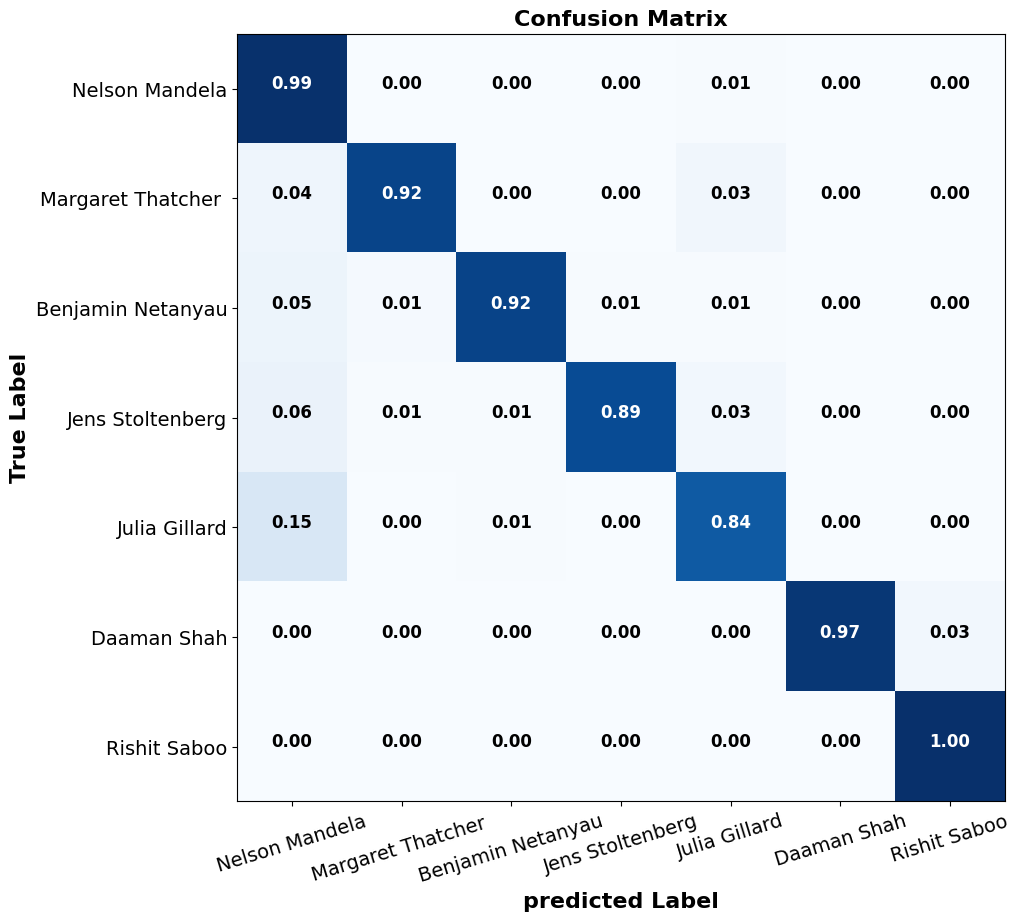

In [38]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report , confusion_matrix, accuracy_score
def plot_confusion_matrix(cm,classes,normalize=False,title='confusion matrix',cmap=plt.cm.Blues):
    if normalize:
        cm =cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("with normalization")
    else:
        print('confusion matrix without normalization')

    plt.imshow(cm,interpolation='nearest', cmap=cmap)
    plt.title(title,weight='bold',fontsize=16)
    tick_marks =np.arange(len(classes))
    plt.xticks(tick_marks,classes,fontsize=14,rotation=17)
    plt.yticks(tick_marks,classes,fontsize=14 )

    fmt='.2f' if normalize else 'd'
    thresh =cm.max()/2.
    for i , j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt), 
                 horizontalalignment="center",fontsize= 12,weight= 'bold',
                 color="white" if cm[i,j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True Label', fontsize=16,weight='bold')
    plt.xlabel('predicted Label', fontsize=16,weight='bold')

cnf_matrix = confusion_matrix(test_y.argmax(axis=1),predicted_labels.argmax(axis=1))
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))

plot_confusion_matrix(cnf_matrix,classes=['Nelson Mandela','Margaret Thatcher ','Benjamin Netanyau','Jens Stoltenberg','Julia Gillard','Daaman Shah','Rishit Saboo'],normalize=True,title="Confusion Matrix")
plt.show()

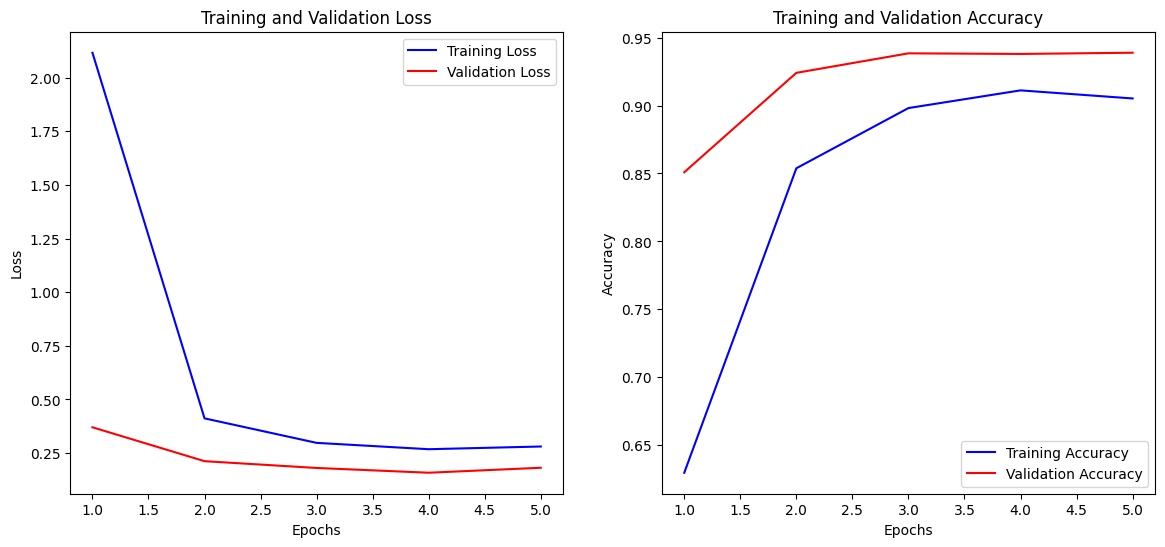

In [40]:
import matplotlib.pyplot as plt
from keras.callbacks import History
import tensorflow as tf


def plot_training_history(h):
    """
    Plots the training and validation loss and accuracy to check for overfitting or underfitting.

    Parameters:
    - history: The history object returned by the model's `fit` method.
    """
    # Extracting data from the history object
    train_loss = h.history['loss']
    val_loss = h.history['val_loss']
    train_acc = h.history['accuracy']
    val_acc = h.history['val_accuracy']

    # Number of epochs
    epochs = range(1, len(train_loss) + 1)

    # Plotting training and validation loss
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Example usage with your model's training history
plot_training_history(h)
